In [65]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm

In [66]:
dataset_size = 20000
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train[:dataset_size].astype("float32") / 127.5 - 1.0
x_train = np.expand_dims(x_train, axis=-1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(dataset_size).batch(128)

In [67]:
T = 1000
betas = np.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas)
sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas = np.sqrt(1.0 / alphas)

def q_sample(x0, t, noise):
    return sqrt_alphas_cumprod[t][:, None, None, None] * x0 + \
           sqrt_one_minus_alphas_cumprod[t][:, None, None, None] * noise

def get_timestep_embedding(timesteps, dim=32):
    half_dim = dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = tf.cast(timesteps, tf.float32)[:, None] * tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
    emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
    return emb

def get_model():
    inp = layers.Input(shape=(28, 28, 1))
    t_inp = layers.Input(shape=(), dtype=tf.int32)

    # Časové embeddingy
    t_emb = get_timestep_embedding(t_inp, dim=64)
    t_emb = layers.Dense(128, activation='relu')(t_emb)
    t_emb = layers.Dense(28 * 28, activation='relu')(t_emb)
    t_emb = layers.Reshape((28, 28, 1))(t_emb)

    # Spojení obrázku a časového vektoru
    x = layers.Concatenate()([inp, t_emb])

    # Blok 1
    x1 = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x1 = layers.BatchNormalization()(x1)

    # Blok 2
    x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(x1)
    x2 = layers.BatchNormalization()(x2)

    # Blok 3
    x3 = layers.Conv2D(64, 3, padding='same', activation='relu')(x2)
    x3 = layers.BatchNormalization()(x3)

    # Residuální spojení (skip connection)
    x_out = layers.Add()([x1, x3])
    x_out = layers.Conv2D(1, 3, padding='same')(x_out)

    return tf.keras.Model([inp, t_inp], x_out)


model = get_model()
optimizer = tf.keras.optimizers.Adam(1e-4)
mse = tf.keras.losses.MeanSquaredError()

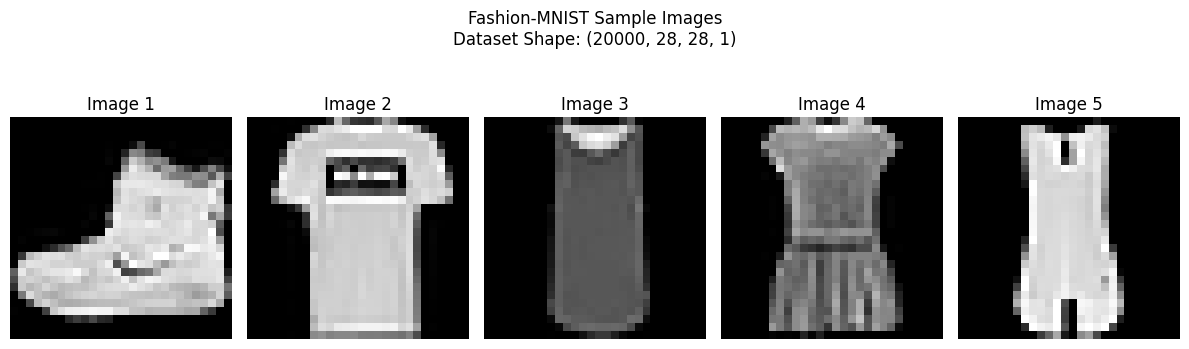

In [68]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    axs[i].imshow((x_train[i] + 1) / 2.0, cmap='gray')
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')
plt.suptitle(f"Fashion-MNIST Sample Images\nDataset Shape: {x_train.shape}")
plt.tight_layout()
plt.show()


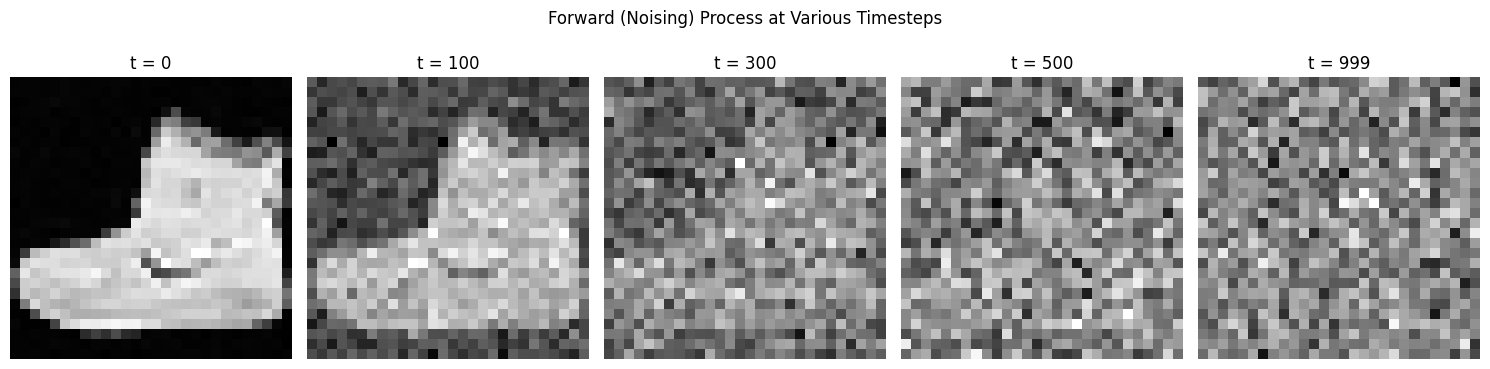

In [69]:
t_vals = [0, 100, 300, 500, 999]
sample_img = x_train[0:1]  # první obrázek

fig, axs = plt.subplots(1, len(t_vals), figsize=(15, 4))
for i, t in enumerate(t_vals):
    noise = tf.random.normal(shape=sample_img.shape)
    x_t = q_sample(sample_img, np.array([t]), noise)
    axs[i].imshow((x_t[0] + 1) / 2.0, cmap='gray')
    axs[i].set_title(f"t = {t}")
    axs[i].axis('off')
plt.suptitle("Forward (Noising) Process at Various Timesteps")
plt.tight_layout()
plt.show()


Epoch 1


100%|██████████| 157/157 [00:38<00:00,  4.11it/s]


Epoch 2


100%|██████████| 157/157 [00:38<00:00,  4.12it/s]


Epoch 3


100%|██████████| 157/157 [00:37<00:00,  4.17it/s]


Epoch 4


100%|██████████| 157/157 [00:38<00:00,  4.12it/s]


Epoch 5


100%|██████████| 157/157 [00:37<00:00,  4.15it/s]


Epoch 6


100%|██████████| 157/157 [00:37<00:00,  4.15it/s]


Epoch 7


100%|██████████| 157/157 [00:37<00:00,  4.13it/s]


Epoch 8


100%|██████████| 157/157 [00:39<00:00,  4.01it/s]


Epoch 9


100%|██████████| 157/157 [00:38<00:00,  4.11it/s]


Epoch 10


100%|██████████| 157/157 [00:38<00:00,  4.12it/s]


Epoch 11


100%|██████████| 157/157 [00:38<00:00,  4.10it/s]


Epoch 12


100%|██████████| 157/157 [00:38<00:00,  4.13it/s]


Epoch 13


100%|██████████| 157/157 [00:39<00:00,  3.96it/s]


Epoch 14


100%|██████████| 157/157 [00:41<00:00,  3.76it/s]


Epoch 15


100%|██████████| 157/157 [00:38<00:00,  4.03it/s]


Epoch 16


100%|██████████| 157/157 [00:38<00:00,  4.06it/s]


Epoch 17


100%|██████████| 157/157 [00:41<00:00,  3.79it/s]


Epoch 18


100%|██████████| 157/157 [00:40<00:00,  3.90it/s]


Epoch 19


100%|██████████| 157/157 [00:38<00:00,  4.10it/s]


Epoch 20


100%|██████████| 157/157 [00:38<00:00,  4.05it/s]


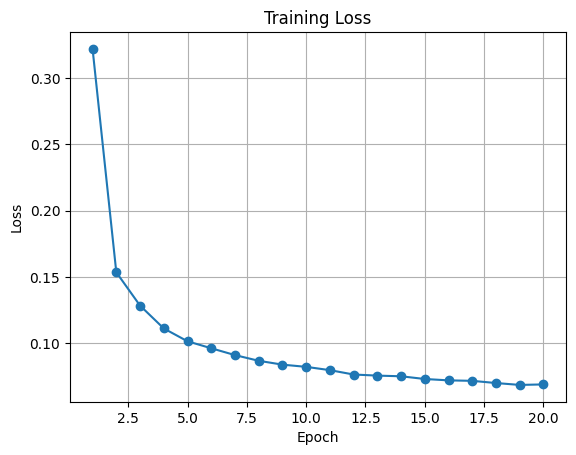

In [70]:
epochs = 20

losses_per_epoch = []

for epoch in range(epochs):
    epoch_losses = []
    print(f"Epoch {epoch+1}")
    for x in tqdm(train_dataset):
        bs = x.shape[0]
        t = np.random.randint(0, T, size=(bs,))
        noise = tf.random.normal(shape=x.shape)
        x_t = q_sample(x, t, noise)
        with tf.GradientTape() as tape:
            pred_noise = model([x_t, t])
            loss = mse(noise, pred_noise)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_losses.append(loss.numpy())
    mean_epoch_loss = np.mean(epoch_losses)
    losses_per_epoch.append(mean_epoch_loss)


plt.plot(range(1, len(losses_per_epoch)+1), losses_per_epoch, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [71]:
def p_sample(model, x, t):
    t_tensor = tf.convert_to_tensor([t] * x.shape[0])

    eps_theta = model([x, t_tensor])

    beta_t = tf.convert_to_tensor(betas[t], dtype=tf.float32)
    sqrt_one_minus_alpha_cumprod_t = tf.convert_to_tensor(sqrt_one_minus_alphas_cumprod[t], dtype=tf.float32)
    sqrt_recip_alpha_t = tf.convert_to_tensor(sqrt_recip_alphas[t], dtype=tf.float32)

    model_mean = sqrt_recip_alpha_t * (x - beta_t / sqrt_one_minus_alpha_cumprod_t * eps_theta)

    if t > 0:
        noise = tf.random.normal(shape=x.shape)
        sigma_t = tf.sqrt(beta_t)
        return model_mean + sigma_t * noise
    else:
        return model_mean


def generate_images(model, n_samples=16):
    x = tf.random.normal((n_samples, 28, 28, 1))
    for t in reversed(range(T)):
        x = p_sample(model, x, t)
    return x

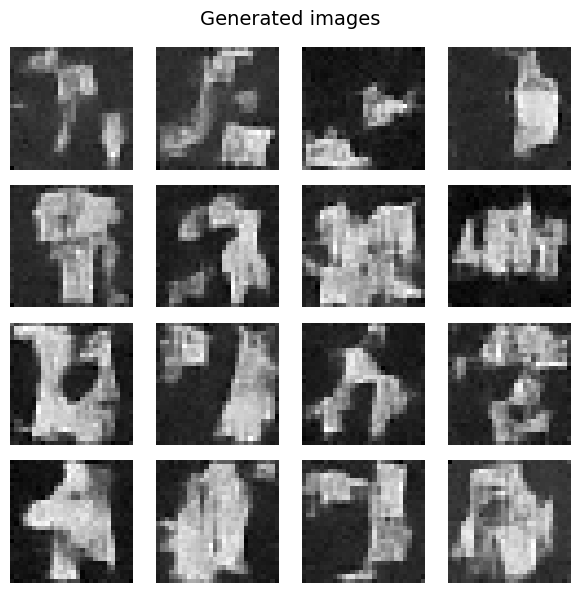

In [72]:
gen_imgs = generate_images(model, n_samples=16).numpy()
gen_imgs = (gen_imgs + 1.0) / 2.0
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(gen_imgs[i, :, :, 0], cmap='gray')
    ax.axis('off')
plt.suptitle("Generated images", fontsize=14)
plt.tight_layout()
plt.show()

## Dataset and Preprocessing

The dataset used in this project is **Fashion-MNIST**, consisting of 60,000 grayscale images of clothing items, each of size 28×28 pixels.
For training, a **subset of 20,000 images** was selected. The images were normalized to the range **[-1, 1]** and reshaped to shape **(28, 28, 1)**.

---

## Diffusion Model Configuration

The forward diffusion process was defined with the following settings:

- **Number of timesteps (T)**: 1000
- **Beta schedule**: linearly spaced between 1e-4 and 0.02
- **Alphas** and **cumulative products** of alphas were precomputed
- The function `q_sample()` adds noise to an image based on the selected timestep `t`

To embed timestep information, a sinusoidal positional embedding function `get_timestep_embedding()` was used, with default dimension 32.

---

## Denoising Model Architecture

The denoising network was a simple convolutional neural network. Key components:

- **Input**: noisy image and integer timestep `t`
- **Time embedding**:
  - Dimension 64
  - Processed via two Dense layers
  - Reshaped to (28, 28, 1) and concatenated with input image

- **Convolutional blocks**:
  - Three `Conv2D(64, kernel_size=3, padding="same", activation="relu")`
  - Followed by `BatchNormalization` layers
  - Final output layer: `Conv2D(1, kernel_size=3, padding="same")`

---

## Training Settings

- **Loss function**: Mean Squared Error (between true and predicted noise)
- **Optimizer**: Adam with learning rate 1e-4
- **Batch size**: 128
- **Epochs**: 20

The model was trained on 20,000 samples for 20 epochs. During training, the loss was tracked and plotted per epoch.

---

## Results

After training, the model was used to generate new images by sampling from pure Gaussian noise and iteratively denoising through all 1000 steps.

The results show that the model was able to generate blurry but recognizable patterns resembling Fashion-MNIST items.
Although the quality is limited due to the shallow architecture and relatively short training, the diffusion process demonstrates the ability to reconstruct structured outputs from random noise.

A forward diffusion visualization for a single image was also included, showing how the image becomes gradually noisier over time.

---

## Conclusion

This project implemented a basic diffusion model on the Fashion-MNIST dataset.
Despite its simplicity, the model was able to learn the noise reversal process and generate low-resolution samples that reflect some key properties of the dataset.

